In [1]:
import pandas as pd
import numpy as np

In [2]:
path="C:/Users/vishal/MLT Project/cleaned_data.csv"
data = pd.read_csv(path)

In [3]:
data.shape

(2339848, 22)

In [4]:
data.size

51476656

In [5]:
data.columns


Index(['Severity', 'Distance(mi)', 'Description', 'Weather_Timestamp',
       'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Visibility(mi)',
       'Wind_Direction', 'Wind_Speed(mph)', 'Weather_Condition', 'Crossing',
       'Give_Way', 'Junction', 'Railway', 'Stop', 'Traffic_Calming',
       'Traffic_Signal', 'Sunrise_Sunset', 'Civil_Twilight',
       'Nautical_Twilight', 'Astronomical_Twilight'],
      dtype='object')

# Remove Outliers

#### Distance(mi), Tempreture(F), Wind_Chill(F), Humidity(%), Visibility(mi), Wind_Speed(mph) shows outliers presents in EDA

In [8]:
from feature_engine.outliers import Winsorizer

In [9]:
winsor = Winsorizer(capping_method='iqr', tail='both', fold=1.5)

<Axes: ylabel='Distance(mi)'>

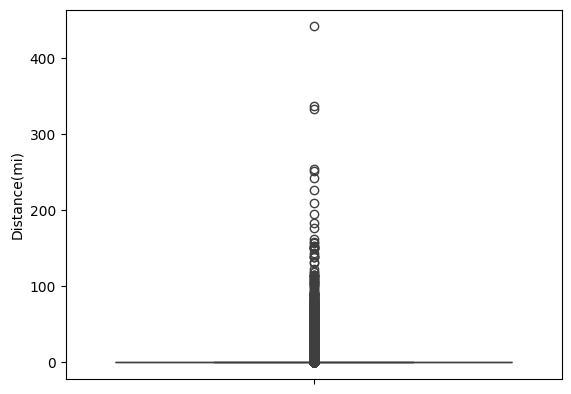

In [10]:
from seaborn import boxplot
boxplot(data['Distance(mi)'])

<Axes: >

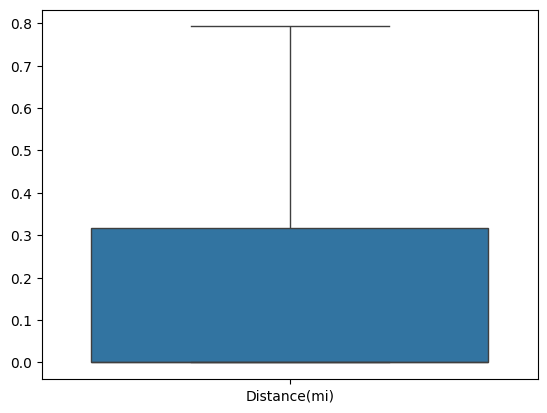

In [11]:
boxplot(winsor.fit_transform(data[['Distance(mi)']]))

#### From above simulation we can clearly see that Winsorizer are capable to remove Outliers

In [13]:
num_cols = list(data.select_dtypes(include='number').columns)[2:]
print(num_cols)

['Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Visibility(mi)', 'Wind_Speed(mph)']


In [14]:
for col in num_cols:
    data[col.lower()] = winsor.fit_transform(data[[col]])

<Axes: ylabel='wind_chill(f)'>

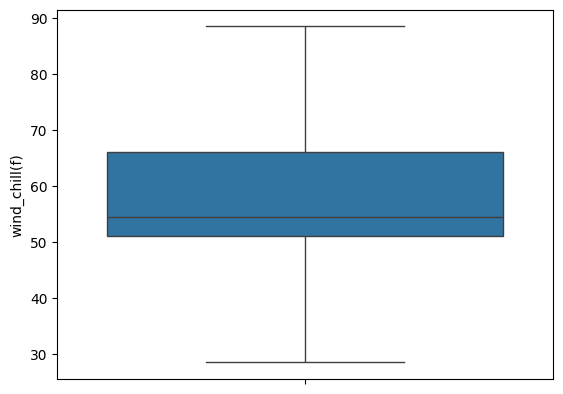

In [15]:
boxplot(data['wind_chill(f)'])

#### Now we have succesfully remove outliers from the dataframe

In [17]:
from sklearn.preprocessing import LabelEncoder
import re

In [18]:
# data['Weather_Timestamp']=LabelEncoder().fit_transform(data['Weather_Timestamp'])
data['Wind_Direction']=LabelEncoder().fit_transform(data['Wind_Direction'])
data['Weather_Condition']=LabelEncoder().fit_transform(data['Weather_Condition'])
data['Crossing']=LabelEncoder().fit_transform(data['Crossing'])
data['Junction']=LabelEncoder().fit_transform(data['Junction'])
data['Railway']=LabelEncoder().fit_transform(data['Railway'])
data['Give_Way']=LabelEncoder().fit_transform(data['Give_Way'])
data['Stop']=LabelEncoder().fit_transform(data['Stop'])
data['Traffic_Calming']=LabelEncoder().fit_transform(data['Traffic_Calming'])
data['Traffic_Signal']=LabelEncoder().fit_transform(data['Traffic_Signal'])
data['Sunrise_Sunset']=LabelEncoder().fit_transform(data['Sunrise_Sunset'])
data['Civil_Twilight']=LabelEncoder().fit_transform(data['Civil_Twilight'])
data['Nautical_Twilight']=LabelEncoder().fit_transform(data['Nautical_Twilight'])
data['Astronomical_Twilight']=LabelEncoder().fit_transform(data['Astronomical_Twilight'])

# Extract Hour and Minute from Weather_Timestamp

In [20]:
data['Weather_Timestamp'] = pd.to_datetime(data['Weather_Timestamp'])

# Extract hour and minute into new columns
data['Hour'] = data['Weather_Timestamp'].dt.hour
data['Minute'] = data['Weather_Timestamp'].dt.minute

# Display the new columns
display(data[['Weather_Timestamp', 'Hour', 'Minute']].head())

,Weather_Timestamp,Hour,Minute
0,2022-04-21 18:19:00,18,19
1,2021-10-11 18:43:00,18,43
2,2021-09-20 05:56:00,5,56
3,2021-01-30 18:53:00,18,53
4,2020-10-12 08:53:00,8,53


#### Drop the Original Weather_Timestamp

In [22]:
data.drop(['Weather_Timestamp'],axis=1,inplace=True)

In [23]:
data.columns

Index(['Severity', 'Distance(mi)', 'Description', 'Temperature(F)',
       'Wind_Chill(F)', 'Humidity(%)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Weather_Condition', 'Crossing', 'Give_Way',
       'Junction', 'Railway', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight', 'temperature(f)', 'wind_chill(f)',
       'humidity(%)', 'visibility(mi)', 'wind_speed(mph)', 'Hour', 'Minute'],
      dtype='object')

In [24]:
data['Severity'].value_counts()

Severity
3    1258196
2     831354
4     188724
1      61574
Name: count, dtype: int64

In [25]:
print(f"Original shape: {data.shape}")

Original shape: (2339848, 28)


## Undersampling - To select only 65000 records from every severity count

In [27]:
target_samples = {1: 61574, 2: 65000, 3: 65000, 4: 65000}

data_1 = data[data['Severity'] == 1]
data_2 = data[data['Severity'] == 2].sample(n=65000, random_state=42)
data_3 = data[data['Severity'] == 3].sample(n=65000, random_state=42)
data_4 = data[data['Severity'] == 4].sample(n=65000, random_state=42)

balanced_data = pd.concat([data_1, data_2, data_3, data_4], axis=0)
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

In [28]:
print(balanced_data['Severity'].value_counts())

Severity
3    65000
4    65000
2    65000
1    61574
Name: count, dtype: int64


In [29]:
balanced_data.shape

(256574, 28)

In [30]:
balanced_data.size

7184072

### Use Sentence Transformer to Encode Description Column into 384 Dimension  using Pretrained model 'all-MiniLM-L6-v2'

In [32]:
from sentence_transformers import SentenceTransformer

C:\Users\vishal\anaconda3\envs\gpu_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Lets create a Model of SentenceTransformer

In [34]:
import warnings
warnings.filterwarnings("ignore")
print("Loading sentence-transformer model...")
model = SentenceTransformer('all-MiniLM-L6-v2')
print("sentence-transformer model loaded")

Loading sentence-transformer model...
sentence-transformer model loaded


#### check the GPU Device Name

In [36]:
import torch
if torch.cuda.is_available():
    print("✅ GPU is available and PyTorch can see it.")
    print(f"Device Name: {torch.cuda.get_device_name(0)}")
else:
    print("❌ ERROR: PyTorch CANNOT see the GPU.")
    print("Make sure you are on a 'T4 GPU' runtime and have restarted.")

✅ GPU is available and PyTorch can see it.
Device Name: NVIDIA GeForce RTX 4050 Laptop GPU


### Create Embedding from the Description Feature from the Dataset

In [38]:
print("\nCreating 384-dimensional embeddings...")
descriptions_list = balanced_data['Description'].tolist()
embeddings_384d = model.encode(descriptions_list, show_progress_bar=False)
print(f"Original embeddings shape: {embeddings_384d.shape}")


Creating 384-dimensional embeddings...
Original embeddings shape: (256574, 384)


#### Create Dataframe of the embedding

In [40]:
df_embeddings = pd.DataFrame(embeddings_384d)
print(df_embeddings.head())

        0         1         2         3         4         5         6    \
0 -0.031039 -0.024782 -0.029882  0.023182 -0.036705  0.020145  0.005980   
1 -0.010555 -0.017489 -0.009972  0.064968 -0.010623  0.087729 -0.031986   
2 -0.031610 -0.014841 -0.009309 -0.008655 -0.016616  0.070522  0.003489   
3 -0.007440  0.013413  0.037686  0.085796  0.038000  0.037211 -0.036286   
4 -0.010627 -0.003295  0.028322  0.003738 -0.059092  0.034926  0.005307   

        7         8         9    ...       374       375       376       377  \
0  0.010886 -0.053237  0.026047  ... -0.000886  0.026007  0.004768 -0.023643   
1  0.084268 -0.018562  0.043472  ... -0.028091  0.032845 -0.015716 -0.026845   
2  0.012801 -0.107920  0.051607  ...  0.022369 -0.012178 -0.001177 -0.026335   
3  0.004467  0.009505  0.057499  ... -0.058709 -0.008362 -0.042577 -0.074947   
4  0.051262 -0.099521  0.089362  ... -0.018172  0.050846  0.027149 -0.021710   

        378       379       380       381       382       383  
0  0

### Let Decompose the 384 dimension to the 100 component using PCA

In [42]:
from sklearn.decomposition import PCA

In [43]:
# Apply Principal Componnet Analysis (PCA)
components = 100
pca = PCA(n_components=100)
embeddings_100d = pca.fit_transform(embeddings_384d)
print(f"PCA complete, NEW SHAPE : {embeddings_100d.shape}")

PCA complete, NEW SHAPE : (256574, 100)


### Create a DATAFRAME for the PCA result
#### It helpful to give them name, like pca_0, pcs_1, etc.

In [45]:
pca_cols = [f"pca_{i}" for i in range(components)]
df_pca_embeddings = pd.DataFrame(embeddings_100d, columns=pca_cols)
print(df_pca_embeddings.head(5))

      pca_0     pca_1     pca_2     pca_3     pca_4     pca_5     pca_6  \
0  0.409557 -0.032874  0.096713 -0.022428  0.029050  0.166107 -0.064768   
1 -0.086811  0.371475 -0.041087  0.179186 -0.061287 -0.046017 -0.017944   
2 -0.338702 -0.026454  0.091858 -0.311811 -0.009279 -0.070546 -0.040686   
3 -0.198721  0.418803  0.091269  0.154974 -0.032048 -0.043287 -0.035610   
4 -0.015605  0.366158 -0.000932  0.198386 -0.082661 -0.040220 -0.024341   

      pca_7     pca_8     pca_9  ...    pca_90    pca_91    pca_92    pca_93  \
0 -0.080750  0.114403  0.035602  ...  0.011294 -0.023450  0.009454 -0.007929   
1 -0.046518 -0.176728  0.050752  ...  0.039491  0.021280 -0.005106 -0.015760   
2 -0.181352 -0.054038 -0.012769  ...  0.012038  0.099881  0.019001  0.063796   
3  0.037654 -0.034167  0.104801  ...  0.008458 -0.063279 -0.003959 -0.030436   
4 -0.038253 -0.103766  0.114418  ... -0.047187  0.015230  0.064401  0.005247   

     pca_94    pca_95    pca_96    pca_97    pca_98    pca_99  
0  0

### Now Create a Dataset of pcs_embeddings and balanced data without 'Description' Feature

In [47]:
processed_data = (pd.concat([(balanced_data.drop("Description", axis=1).reset_index(drop=True)), (df_pca_embeddings.reset_index(drop=True))], axis=1))

In [48]:
print(processed_data.head(5))

   Severity  Distance(mi)  Temperature(F)  Wind_Chill(F)  Humidity(%)  \
0         3         0.000            72.0      72.000000         26.0   
1         4         1.002            91.8      54.472104         48.0   
2         1         0.000            91.0      91.000000         38.0   
3         4         1.500            77.0      77.000000         40.0   
4         4         0.180            73.0      54.472104         26.0   

   Visibility(mi)  Wind_Direction  Wind_Speed(mph)  Weather_Condition  \
0            10.0               6             10.0                 16   
1            10.0              22             18.4                  6   
2            10.0              20              7.0                 16   
3            10.0              10             12.0                 91   
4            10.0              10             15.0                 91   

   Crossing  ...    pca_90    pca_91    pca_92    pca_93    pca_94    pca_95  \
0         0  ...  0.011294 -0.023450  0.00

### Svae the Dataframe into CSV File

In [84]:
processed_data.to_csv("Processed_data.csv")